# NFL Money Line Analyzer #

This Notebook uses the season stats of NFL teams to predict the outcome of match ups. The data is then run through a Decision Tree, Random Forest, and Naive Bayes classifiers.

The data is sourced from footballdb.com

CSV files besides matchup2.csv must have team names in alphabetical order

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics  
from sklearn import tree
import numpy as np
from matplotlib import pyplot as plt

pass_df = pd.read_csv('PassRippedData.csv')
rush_df = pd.read_csv('RushRippedData.csv') 
passD_df = pd.read_csv('Pass_DRippedData.csv') 
rushD_df = pd.read_csv('Rush_DRippedData.csv')
matchup_df = pd.read_csv('matchup2.csv')
teamlist_df = pd.read_csv('teamlist.csv')

teamlist_df = teamlist_df.set_index('Team')

# Data Cleaning Functions #

The function MoreIsBetter is best used for simplifying team wins, postive offensive production (yards gained, first downs, touchdowns), and defensive stats (3rd down stops, turnovers).

The function LessIsBetter is best used for simplifying negative offensive production (interceptions, fumbles, 3 and outs) and positive defensive production (passing/rushing yards allowed, touchdowns allowed)

In [2]:
def MoreIsBetter(stat_df, col_name):
    """
    stat_df: pass a data frame containing column to be simplified
    col_name: column name of stat to be simplified
    
    return: n/a
    """

    stat_pg = stat_df[col_name]

    avg_stat = 0
    for x in stat_pg:
        avg_stat += int(x)

    avg_stat = int(avg_stat / 32)

    for x in stat_pg:
        if x > avg_stat:
            stat_pg.replace(x, 1, inplace=True)

    for x in stat_pg:
        if x > 2:
            stat_pg.replace(x, 0, inplace=True)

def LessIsBetter(stat_df, col_name):
    """
    stat_df: pass a data frame containing column to be simplified
    col_name: column name of stat to be simplified
    
    return: n/a 
    """

    stat_pg = stat_df[col_name]

    avg_stat = 0
    for x in stat_pg:
        avg_stat += int(x)

    avg_stat = int(avg_stat / 32)

    for x in stat_pg:
        if x < avg_stat:
            stat_pg.replace(x, 1, inplace=True)

    for x in stat_pg:
        if x > 2:
            stat_pg.replace(x, 0, inplace=True)

# Data Frame Combination Function #

Takes the binary data created from MoreIsBetter and LessIsBetter to create a single data frame. 

In [3]:
def combination(matchup_df, teamlist_df, col_name1, stat_df, col_name2):
    """
    parameters
    teamlist_df: starts as csv with only list of team names, becomes the df for the classifiers
    col_name1: name of column being added to teamlist_df
    stat_df: binary stat being added
    col_name2: name of column in stat_df with binary data in it 
    """
    matchup_df.replace('0', 0, inplace=True) # make everything binary
    matchup_df.replace('1', 1, inplace=True)
        
    teamlist_df[col_name1] = stat_df[col_name2].tolist()
        
    HT_stat_list = []

    for x in matchup_df['Home Team']:
        HT_stat_list.append(teamlist_df.loc[x, col_name1])
        
    matchup_df['HT ' + col_name1] = HT_stat_list
    
    AT_stat_list = []

    for x in matchup_df['Away Team']:
        AT_stat_list.append(teamlist_df.loc[x, col_name1])        
    
    matchup_df['AT ' + col_name1] = AT_stat_list
    

# Turning Data into 1s and 0s #
# and Combining Dataframes #

matchup_df will be used for the classifiers. This cell is used to modify the data using MoreIsBetter and LessIsBetter and then inputing it into matchup_df 

In [4]:
# Yards gained per game by pass or rush
MoreIsBetter(pass_df, 'Yds/G')
MoreIsBetter(rush_df, 'Yds/G')

# Yards allowed per game by pass or rush
LessIsBetter(passD_df, 'Yds/G')
LessIsBetter(rushD_df, 'Yds/G')

# Touchdowns Scored per game by pass or rush
MoreIsBetter(pass_df, 'TD')
MoreIsBetter(rush_df, 'TD')

# Touchdowns Allowed per game by pass or rush
LessIsBetter(passD_df, 'TD')
LessIsBetter(rushD_df, 'TD')

# Interceptions thrown by Offense
#LessIsBetter(pass_df, 'Int')

# Interceptions caught by Defense
#MoreIsBetter(passD_df, 'Int')


combination(matchup_df, teamlist_df, 'Above Average Rush O', rush_df, 'Yds/G')
combination(matchup_df, teamlist_df, 'Above Average Pass O', pass_df, 'Yds/G')
combination(matchup_df, teamlist_df, 'Above Average Rush D', rushD_df, 'Yds/G')
combination(matchup_df, teamlist_df, 'Above Average Pass D', passD_df, 'Yds/G')
combination(matchup_df, teamlist_df, 'Above Average Rush Touchdowns O', rush_df, 'TD')
combination(matchup_df, teamlist_df, 'Above Average Pass Touchdowns O', pass_df, 'TD')
combination(matchup_df, teamlist_df, 'Above Average Rush Touchdowns D', rushD_df, 'TD')
combination(matchup_df, teamlist_df, 'Above Average Pass Touchdowns D', passD_df, 'TD')
#combination(matchup_df, teamlist_df, 'Below Average Interceptions by O', pass_df, 'Int')
#combination(matchup_df, teamlist_df, 'Above Average Interceptions by D', passD_df, 'Int')



#matchup_df
#teamlist_df

## Decision Tree ##

Decision Tree Accuracy: 0.75


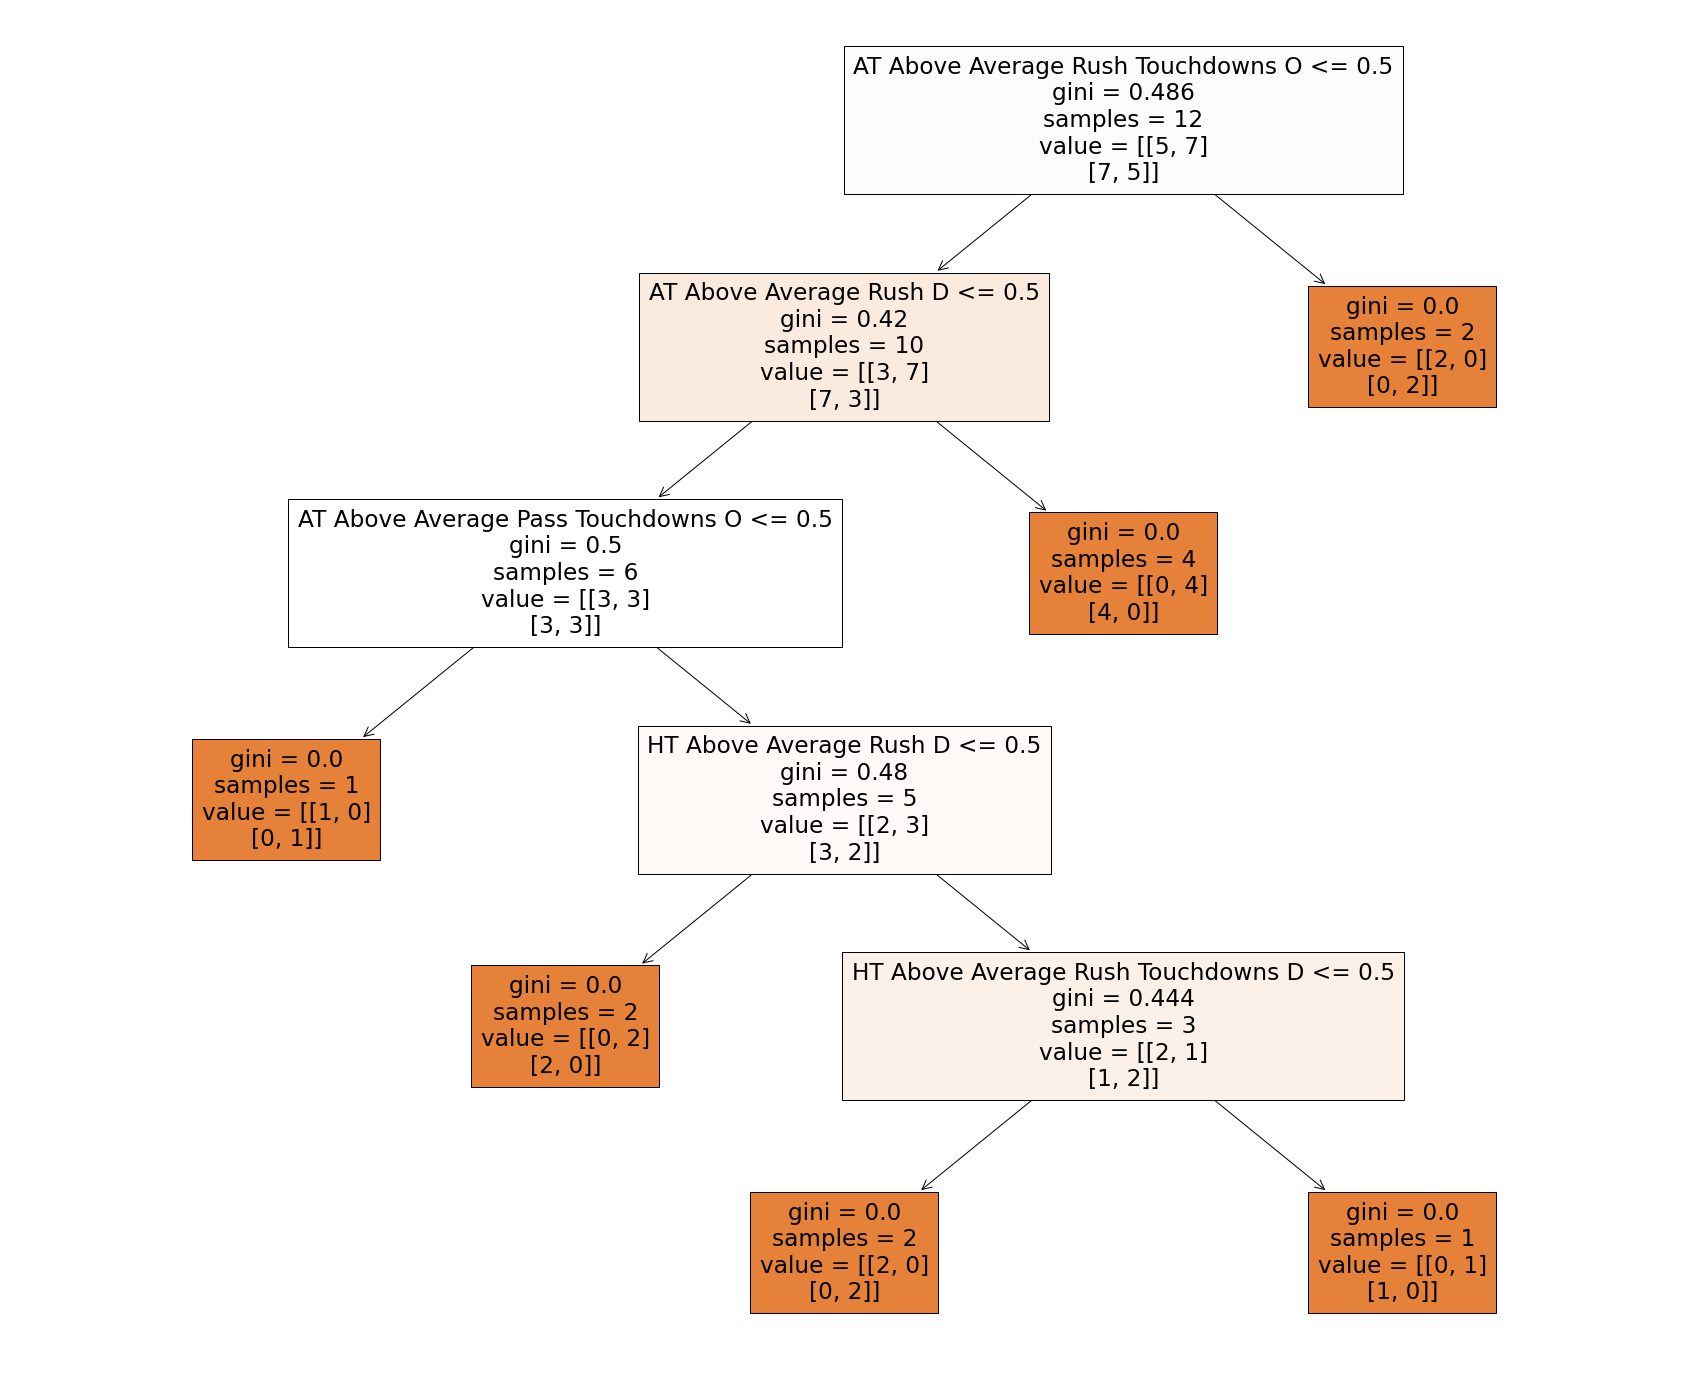

In [5]:
matchup_df2 = matchup_df.drop('Home Team Win', axis=1) 
matchup_df2 = matchup_df2.drop('Home Team', axis=1) 
matchup_df2 = matchup_df2.drop('Away Team', axis=1) 

x = matchup_df2
y = matchup_df['Home Team Win']

y = pd.get_dummies(y) 

xTrain, xTest, yTrain, yTest = train_test_split(x, y, random_state=1) # Splitting the data 

dtc = DecisionTreeClassifier() # creating the Decision Tree

dtc.fit(xTrain, yTrain) # inputing the training model

ig = plt.figure(figsize=(30,25)) # outputting the Tree 
_ = tree.plot_tree(dtc, feature_names = matchup_df2.columns, class_names = True, filled=True )

yPred = dtc.predict(xTest) # Running the tree with all the data 

print("Decision Tree Accuracy:", metrics.accuracy_score(yTest, yPred)) # running test vs training for accuracy 


## Naive Bayes ##

In [6]:
y = matchup_df['Home Team Win']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, random_state=1) # Splitting the data 

gnb = GaussianNB()

gnb.fit(xTrain, yTrain)

yPred = gnb.predict(xTest)

print("Number of mislabeled points out of a total %d points : %d"
       % (xTest.shape[0], (yTest != yPred).sum()))


print("Naive Bayes Accuracy:", metrics.accuracy_score(yTest, yPred)) # 

Number of mislabeled points out of a total 4 points : 3
Naive Bayes Accuracy: 0.25


## Findings ##

The Decision Tree's accuracy is much higher because it is a better fit for this data than Naive Bayes.

The Decision Tree is allowed to prune data and builds its own classifier wheras the Naive Bayes is forced to use all the data provided lowering its accuracy.

One way to improve the outcome of both classifiers is to weigh certain columns that are higher predictors of success.

The Random Forest Classifier sometimes yields an equal accuracy to the Decision Tree but that is a testament to its randomness and its best performing classifier is not always equal or greater than the Decision Tree.

In [12]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

print("Random Forest Accuracy:", metrics.accuracy_score(yTest, yPred))

Random Forest Accuracy: 0.75
